<a href="https://colab.research.google.com/github/Layantt/Data-Science-Project/blob/main/DataScience.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os, re, pandas as pd
from pathlib import Path
from IPython.display import display
from google.colab import files
OUT = Path("raw_data"); OUT.mkdir(exist_ok=True)


In [ ]:
# Required Libraries Installation
import subprocess, sys, os, re
from datetime import datetime

def install_packages():
    packages = ["requests", "beautifulsoup4", "pandas", "lxml", "urllib3", "certifi"]
    for package in packages:
        try:
            __import__(package.replace("beautifulsoup4", "bs4"))
        except ImportError:
            subprocess.run([sys.executable, "-m", "pip", "install", package], check=True)

install_packages()

# Imports
import requests, pandas as pd
import certifi
from bs4 import BeautifulSoup
from google.colab import files
from pathlib import Path
import urllib3

# Disable only the SSL warning if we fall back to verify=False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Output dir
output_dir = Path("raw_data")
output_dir.mkdir(exist_ok=True)
html_file = output_dir / "pdpl_raw_html.html"
csv_file  = output_dir / "pdpl_articles_enhanced.csv"

url = "https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}

print("Starting enhanced data collection with article status detection...")

def fetch_with_fallback(url, headers, timeout=30):
    """
    1) Try with default CA bundle (secure)
    2) Try with certifi.where() (explicit CA path)
    3) Last resort: verify=False (insecure, but pragmatic for Colab scraping)
    """
    try:
        r = requests.get(url, headers=headers, timeout=timeout)  # default
        r.raise_for_status()
        return r, "secure-default"
    except Exception as e1:
        try:
            r = requests.get(url, headers=headers, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r, "secure-certifi"
        except Exception as e2:
            # Final fallback (NOT for prod; just to proceed in Colab)
            r = requests.get(url, headers=headers, timeout=timeout, verify=False)
            r.raise_for_status()
            return r, "insecure-fallback"

try:
    response, mode = fetch_with_fallback(url, headers)
    print(f"HTTP GET OK via mode: {mode} | status={response.status_code}")

    # Save raw HTML for inspection
    html_file.write_text(response.text, encoding="utf-8")
    print(f"Raw HTML saved: {html_file}")

    soup = BeautifulSoup(response.text, "lxml")

    # Try structured extraction first
    articles_from_html = []
    article_divs = soup.find_all("div", class_="article_item")

    if article_divs:
        print(f"Found {len(article_divs)} article divs in HTML structure")
        for div in article_divs:
            classes = div.get("class", [])
            if "changed-article" in classes:
                article_status = "معدلة"
            elif "no_alternate" in classes:
                article_status = "أصلية"
            else:
                article_status = "غير محدد"

            title_element = div.find("h3")
            article_title = title_element.get_text(strip=True) if title_element else "عنوان غير محدد"

            content_div = div.find("div", class_="HTMLContainer")
            if content_div:
                article_text = content_div.get_text(separator=" ", strip=True)
                modification_text = "لا يوجد نص معدل"

                if article_status == "معدلة":
                    popup_div = div.find("div", class_="article_item_popup")
                    if popup_div:
                        popup_content = popup_div.find("div", class_="HTMLContainer")
                        if popup_content:
                            popup_text = popup_content.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text
                        else:
                            popup_text = popup_div.get_text(separator=" ", strip=True)
                            if popup_text and len(popup_text) > 10:
                                modification_text = popup_text

                if article_text and len(article_text) > 10:
                    articles_from_html.append({
                        "article_title": article_title,
                        "article_text": article_text,
                        "article_status": article_status,
                        "modification_text": modification_text
                    })

    # Fallback to text parsing if needed
    articles_from_text = []
    if not articles_from_html:
        print("No structured HTML found, falling back to text extraction...")
        text = soup.get_text(separator="\n", strip=True)
        lines = text.split("\n")
        current_article, current_content, article_found = None, [], False

        for line in lines:
            line = line.strip()
            if not line:
                continue
            if re.match(r"^المادة\s+", line):
                if current_article and current_content and article_found:
                    article_text = " ".join(current_content).strip()
                    if len(article_text) > 10:
                        article_status = "أصلية"
                        modification_text = "لا يوجد نص معدل"
                        if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                            article_status = "معدلة"
                            patterns = [
                                r'عُدلت هذه المادة.*?"(.*?)"',
                                r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                                r'لتكون بالنص الآتي.*?"(.*?)"'
                            ]
                            for pattern in patterns:
                                m = re.search(pattern, article_text, re.DOTALL)
                                if m:
                                    modification_text = m.group(1).strip()
                                    break
                            if modification_text == "لا يوجد نص معدل":
                                mod_start = article_text.find("عُدلت هذه المادة")
                                if mod_start != -1:
                                    modification_text = article_text[mod_start:mod_start+200] + "..."

                        articles_from_text.append({
                            "article_title": current_article,
                            "article_text": article_text,
                            "article_status": article_status,
                            "modification_text": modification_text
                        })
                current_article, current_content, article_found = line, [], True
            else:
                if current_article and article_found:
                    if len(line) <= 3:
                        continue
                    skip_line = False
                    if (line.startswith("تاريخ") or line.startswith("رقم") or
                        line.startswith("الجريدة الرسمية") or line.startswith("*") or line.startswith("-")):
                        skip_line = True
                    admin_only = ["تعديلات المادة", "مادة معدلة", "مادة ملغية"]
                    line_lower = line.lower()
                    for pat in admin_only:
                        if pat in line_lower and len(line) < 150 and line.count('.') <= 1:
                            skip_line = True
                            break
                    if not skip_line:
                        current_content.append(line)

        if current_article and current_content and article_found:
            article_text = " ".join(current_content).strip()
            if len(article_text) > 10:
                article_status = "أصلية"
                modification_text = "لا يوجد نص معدل"
                if any(ind in article_text for ind in ["عُدلت هذه المادة", "المرسوم الملكي", "بموجب", "معدلة"]):
                    article_status = "معدلة"
                    patterns = [
                        r'عُدلت هذه المادة.*?"(.*?)"',
                        r'بموجب.*?المرسوم الملكي.*?(.*?)(?:\.|$)',
                        r'لتكون بالنص الآتي.*?"(.*?)"'
                    ]
                    for pattern in patterns:
                        m = re.search(pattern, article_text, re.DOTALL)
                        if m:
                            modification_text = m.group(1).strip()
                            break
                    if modification_text == "لا يوجد نص معدل":
                        mod_start = article_text.find("عُدلت هذه المادة")
                        if mod_start != -1:
                            modification_text = article_text[mod_start:mod_start+200] + "..."

                articles_from_text.append({
                    "article_title": current_article,
                    "article_text": article_text,
                    "article_status": article_status,
                    "modification_text": modification_text
                })

    # Prefer HTML-based; else text-based; else empty
    articles = articles_from_html if articles_from_html else articles_from_text

    # Build DataFrame (even if empty, but with columns)
    cols = ["article_title", "article_text", "article_status", "modification_text"]
    df = pd.DataFrame(articles, columns=cols)

    # Basic cleaning
    if not df.empty:
        df = df[df["article_text"].astype(str).str.len() > 10]
        df = df.drop_duplicates(subset=["article_title"])
        first_articles = df[df["article_title"].astype(str).str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
        if len(first_articles) > 1:
            print("Detected duplicate first article - fixing...")
            best_first = first_articles.loc[first_articles["article_text"].str.len().idxmax()]
            df = df[~df["article_title"].str.contains("المادة الأولى|المادة \\(1\\)|المادة ١", case=False, na=False, regex=True)]
            df = pd.concat([pd.DataFrame([best_first]), df]).reset_index(drop=True)

    # Always write a CSV so Cell 2 never fails with FileNotFound
    df.to_csv(csv_file, index=False, encoding="utf-8-sig")
    print(f"Successfully extracted {len(df)} articles with status information!")
    print(f"Enhanced data saved to: {csv_file}")

    # Quick stats
    print("CWD:", Path.cwd())
    print("raw_data contents:", [p.name for p in output_dir.iterdir()])

    if not df.empty:
        print("\n Article Status Summary:")
        print("-" * 40)
        for status, count in df['article_status'].value_counts().items():
            print(f"• {status}: {count} مادة")

except Exception as e:
    # As a last resort, create an empty CSV with columns so Cell 2 won't crash
    print(f" Error in data collection: {e}")
    if not csv_file.exists():
        pd.DataFrame(columns=["article_title", "article_text", "article_status", "modification_text"]).to_csv(csv_file, index=False, encoding="utf-8-sig")
        print("Created empty CSV due to error, to keep the pipeline alive.")

print("\n Files saved in directory:", output_dir)
print(" Enhanced data collection completed (with fallbacks).")
try:
    files.download(str(html_file))
    files.download(str(csv_file))
except:
    print(" Files ready for download in the output directory")


# secondary data

In [16]:
# Secondary dataset (does NOT override your primary df)
def build_secondary():
    data = [
        ["id","question","answer"],
        [1,"ما هي البيانات الشخصية؟","كل معلومة تتعلق بفرد يمكن تحديده مباشرة أو غير مباشرة مثل الاسم أو رقم الهوية أو البريد الإلكتروني"],
        [2,"ما هي البيانات الحساسة؟","البيانات المتعلقة بالصحة أو الدين أو السياسة أو الجوانب المالية، أو البيومترية عند استخدامها للتعرف"],
        [3,"هل يجب الحصول على موافقة صاحب البيانات؟","نعم، الموافقة صريحة ومستنيرة قبل المعالجة إلا في حالات محددة منصوص عليها في النظام"],
        [4,"ما الحقوق الأساسية لصاحب البيانات؟","الإطلاع، التصحيح، المسح، الاعتراض على المعالجة، ونقل البيانات"],
        [5,"هل يجوز نقل البيانات خارج المملكة؟","نعم، بعد توفر ضمانات مناسبة أو موافقة صاحب البيانات"],
        [6,"متى يجب الإبلاغ عن تسريب البيانات؟","عند وجود خطر محتمل على خصوصية الأفراد أو على النظام"],
        [7,"ما دور مسؤول حماية البيانات؟","متابعة الامتثال للنظام، تقييم المخاطر، وتدريب العاملين"],
        [8,"هل يمكن سحب الموافقة بعد منحها؟","نعم، يمكن لصاحب البيانات سحب موافقته في أي وقت"],
        [9,"ما واجبات الجهة المتحكمة؟","تحديد الأغراض ووسائل المعالجة، ضمان حماية البيانات، والتقيد بالأنظمة"],
        [10,"ما معنى مبدأ التقليل من البيانات؟","جمع أقل قدر ممكن من البيانات اللازمة فقط لتحقيق الغرض"],
        [11,"ما هي أهداف نظام حماية البيانات الشخصية؟","حماية خصوصية الأفراد، تنظيم معالجة البيانات، وزيادة الثقة الرقمية"],
        [12,"هل يشمل النظام الجهات الحكومية والخاصة؟","نعم، أي جهة تتعامل مع البيانات الشخصية لأفراد داخل المملكة"],
        [13,"ما هي طرق حماية البيانات المقترحة في الدراسات؟","استخدام التشفير، إدارة الحقوق، التدريب، وضوابط الوصول الصارمة"],
        [14,"هل يمكن معالجة البيانات دون موافقة؟","فقط إذا كان هناك أساس قانوني أو مصلحة عامة مشروعة"],
        [15,"ما الفرق بين المتحكم والمعالج؟","المتحكم يحدد الغرض، المعالج ينفذ المعالجة نيابة عنه وفق عقد"],
        [16,"ما هي العقوبات عند مخالفة النظام؟","غرامات مالية أو إجراءات قانونية حسب نوع المخالفة وخطورتها"],
        [17,"هل يمكن استخدام البيانات لأغراض تسويقية؟","فقط بعد موافقة صريحة من صاحب البيانات مع إمكانية سحبها"],
        [18,"ما واجب الجهة عند اكتشاف تسريب بيانات؟","تقييم الخطر، إخطار الهيئة المختصة، وإعلام المتأثرين إذا لزم الأمر"],
        [19,"هل يجب توثيق جميع عمليات المعالجة؟","نعم، لحفظ سجل كامل للامتثال والتحقق."],
        [20,"هل يمتد النظام للأشخاص المقيمين خارج المملكة؟","نعم، إذا كانت البيانات تخص أفراداً داخل السعودية"],
        [21,"ما هو مبدأ الشفافية في معالجة البيانات؟","إبلاغ الأفراد بطريقة واضحة عن كيفية جمع واستخدام بياناتهم"],
        [22,"هل يجب إعلام الأفراد بحقوقهم؟","نعم، مثل الحق في الإطلاع والتصحيح والسحب والاعتراض"],
        [23,"ما هي البيانات التي تحتاج حماية إضافية؟","البيانات الحساسة أو البيانات الكبيرة الحجم أو بيانات الأطفال"],
        [24,"ما دور التدريب في الامتثال للنظام؟","رفع وعي الموظفين وتقليل المخاطر الناتجة عن الأخطاء البشرية"],
        [25,"هل يحق لصاحب البيانات الاعتراض على المعالجة؟","نعم، إذا لم تكن المعالجة مستندة إلى أساس قانوني أو مصلحة مشروعة"],
        [26,"ما معنى الحد من التخزين؟","حذف أو إتلاف البيانات عند انتهاء الغرض منها"],
        [27,"هل النظام يشمل البيانات الرقمية وغير الرقمية؟","نعم، أي بيانات شخصية مخزنة بأي شكل كانت"],
        [28,"ما علاقة النظام بالأمن السيبراني؟","يشكل جزءاً من الإطار القانوني لحماية البيانات الرقمية ومنع التسريبات"],
        [29,"هل يمكن تعديل بيانات الأفراد؟","نعم، عند وجود خطأ أو طلب من صاحب البيانات"],
        [30,"ما أهمية الامتثال للنظام؟","يعزز الثقة بين الأفراد والجهات ويجنب العقوبات القانونية ويحمي الخصوصية"]
    ]

    header, rows = data[0], data[1:]
    def clean(x):
        x = str(x).strip()
        x = re.sub(r"[^\w\s\u0600-\u06FF\-\–\—.,;؟?!%()«»]+", "", x)
        return re.sub(r"\s+", " ", x)

    cleaned = [[clean(v) for v in r] for r in rows]
    df_secondary = pd.DataFrame(cleaned, columns=header)

    path = OUT / "pdpl_secondary_nonofficial.csv"
    df_secondary.to_csv(path, index=False, encoding="utf-8-sig")

    display(df_secondary.head(30))
    files.download(str(path))
    print("saved ", path)
    return df_secondary

df_secondary = build_secondary()


,id,question,answer
0,1,ما هي البيانات الشخصية؟,كل معلومة تتعلق بفرد يمكن تحديده مباشرة أو غير...
1,2,ما هي البيانات الحساسة؟,البيانات المتعلقة بالصحة أو الدين أو السياسة أ...
2,3,هل يجب الحصول على موافقة صاحب البيانات؟,نعم، الموافقة صريحة ومستنيرة قبل المعالجة إلا ...
3,4,ما الحقوق الأساسية لصاحب البيانات؟,الإطلاع، التصحيح، المسح، الاعتراض على المعالجة...
4,5,هل يجوز نقل البيانات خارج المملكة؟,نعم، بعد توفر ضمانات مناسبة أو موافقة صاحب الب...
5,6,متى يجب الإبلاغ عن تسريب البيانات؟,عند وجود خطر محتمل على خصوصية الأفراد أو على ا...
6,7,ما دور مسؤول حماية البيانات؟,متابعة الامتثال للنظام، تقييم المخاطر، وتدريب ...
7,8,هل يمكن سحب الموافقة بعد منحها؟,نعم، يمكن لصاحب البيانات سحب موافقته في أي وقت
8,9,ما واجبات الجهة المتحكمة؟,تحديد الأغراض ووسائل المعالجة، ضمان حماية البي...
9,10,ما معنى مبدأ التقليل من البيانات؟,جمع أقل قدر ممكن من البيانات اللازمة فقط لتحقي...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saved  raw_data/pdpl_secondary_nonofficial.csv


# Data Processing and Cleaning

In [ ]:
from pathlib import Path
import pandas as pd

base = Path("raw_data")
print("CWD:", Path.cwd())
print("raw_data contents:", [p.name for p in base.glob("*")])

target = base / "pdpl_articles_enhanced.csv"
if not target.exists():
    raise FileNotFoundError("CSV not found. Re-run Cell 1 successfully first.")

# ترميز utf-8-sig
df = pd.read_csv(target, encoding="utf-8-sig")
print("Loaded file:", target)
print("Initial shape:", df.shape)
df.info()

# checking out
display(df.head(2))


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated(subset=["article_title"]).sum()
print(f"\nDuplicate articles found: {duplicates}")

# Display sample
df.head()


In [ ]:
import re

def clean_text(text):
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove non-Arabic or special symbols if any
    text = re.sub(r'[^\u0600-\u06FF\s.,؛:،]', '', text)
    return text.strip()

# Apply cleaning
df["article_text"] = df["article_text"].apply(clean_text)
df["modification_text"] = df["modification_text"].apply(clean_text)


In [ ]:
# Normalize status column to ensure consistency
df["article_status"] = df["article_status"].replace({
    "معدلة": "Modified",
    "أصلية": "Original",
    "غير محدد": "Unknown"
})


In [ ]:
# Save the cleaned and processed dataset
cleaned_file = "raw_data/pdpl_cleaned.csv"
df.to_csv(cleaned_file, index=False, encoding="utf-8-sig")

print(f" Cleaned dataset saved to: {cleaned_file}")


In [ ]:
#Download
from google.colab import files
files.download("raw_data/pdpl_cleaned.csv")


# Exploratory Data Analysis (EDA):
## for both primary and secondary

#### in this section we'll show:

1. Statistical Patterns
2. Visualizations
3. Text Correlations
4. Metadata Review
5. Bias Awareness


## **EDA for primary data:**

 ## 1. Statistical Summaries (Uncover patterns, trends, and anomalies):

In [ ]:
df = pd.read_csv('raw_data/pdpl_cleaned.csv')
# exploring the table
df.info()
print('========================================================')
df.describe()

In [ ]:
# calculating the texts length


df['text_length'] = df['article_text'].str.len()
print(df['text_length'])
print('========================================================')
print(df['text_length'].describe())

In [ ]:
# calculate how many words in the article text column

df['word_count'] = df['article_text'].apply(lambda x: len(x.split()))
print(df['word_count'].describe())

In [ ]:
# most repetitive words
# using pandas

pd.Series(tokens).value_counts().head(20)


In [ ]:
# show the outliers

threshold_high = df['word_count'].quantile(0.95)
threshold_low = df['word_count'].quantile(0.05)

df_outliers = df[(df['word_count'] < threshold_low) | (df['word_count'] > threshold_high)]

# print(df_outliers) {too messy}

# to make output more clear
df_outliers.style.set_caption("Outliers in word count")


## 2. Visualization:

In [ ]:
# Histogram for texts length
import matplotlib.pyplot as plt

plt.hist(df['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Bar Plot for most repetitive words:


text = " ".join(df['article_text'].astype(str))
tokens = re.findall(r"\w+", text, flags=re.UNICODE)

word_freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(12,6))
word_freq.sort_values().plot(kind='barh', color='#3b82f6')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

In [ ]:
freq = pd.Series(dict(Counter(tokens))).sort_values(ascending=False)[:20]
freq.plot(kind='bar', figsize=(12,6))
plt.title('Top 20 Words')
plt.show()


In [ ]:
# Boxplot لطول النصوص حسب حالة المادة
import seaborn as sns

df['text_length'] = df['article_text'].apply(lambda x: len(str(x).split())) # add the column text len

sns.boxplot(x='article_status', y='text_length', data=df)
plt.title('Text Length by Status')
plt.show()

## 3. Correlation / Relationships analysis

In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display

assert {'article_text','article_status'}.issubset(df.columns), "Expected columns missing."
df = df.copy()

#Tokenizer
def tokenize_ar(text):
    return re.findall(r"\w+", str(text), flags=re.UNICODE)

AR_STOP = {
    'من','في','على','و','او','أو','إلى','الى','أن','إن','لا','ما','عن','مع','هذا','هذه','ذلك','تلك',
    'هو','هي','ها','هما','هم','هن','أ','يا','كل','أي','أيضاً','قد','كما','لكن','بل','ثم','لدى',
    'لها','له','لهم','لهن','كان','كانت','يكون','تكون','كون','هناك','هنا','حتى','اذا','إذا','بما','ومن','فإن'
}

if 'text_length' not in df.columns:
    df['text_length'] = df['article_text'].apply(lambda x: len(str(x)))
if 'word_count' not in df.columns:
    df['word_count'] = df['article_text'].apply(lambda x: len(tokenize_ar(x)))

print("=== Length / Count by Status ===")
display(df.groupby('article_status')[['word_count','text_length']].agg(['mean','median','min','max','std']).round(2))

# Top words per status ( after removing stopwords)
print("\n=== Top Words per Status (stopwords removed) ===")
for status in df['article_status'].unique():
    subset = df[df['article_status'] == status]
    toks = []
    for t in subset['article_text']:
        toks.extend(tokenize_ar(t))
    toks = [w for w in toks if w not in AR_STOP and len(w) > 1]
    top = Counter(toks).most_common(15)
    top_df = pd.DataFrame(top, columns=['word','count'])
    print(f"\n[Status = {status}]")
    display(top_df)

#TF-IDF:
print("\n=== TF-IDF Distinctive Terms per Status ===")
vectorizer = TfidfVectorizer(
    max_features=2000,
    analyzer='word',
    token_pattern=r'\w+',
    lowercase=False
)
X = vectorizer.fit_transform(df['article_text'])
vocab = np.array(vectorizer.get_feature_names_out())

mask_mod = (df['article_status'] == 'Modified').to_numpy()
mask_org = (df['article_status'] == 'Original').to_numpy()
idx_mod = np.where(mask_mod)[0]
idx_org = np.where(mask_org)[0]

if idx_mod.size > 0:
    mean_mod = np.asarray(X[idx_mod].mean(axis=0)).ravel()
else:
    mean_mod = np.zeros(X.shape[1])

if idx_org.size > 0:
    mean_org = np.asarray(X[idx_org].mean(axis=0)).ravel()
else:
    mean_org = np.zeros(X.shape[1])

def top_terms(mean_vec, k=15):
    idx = mean_vec.argsort()[::-1][:k]
    return pd.DataFrame({'term': vocab[idx], 'score': mean_vec[idx]})

print("\nTop TF-IDF terms (Modified):")
display(top_terms(mean_mod, 15))

print("\nTop TF-IDF terms (Original):")
display(top_terms(mean_org, 15))

diff = mean_mod - mean_org
print("\nMost distinctive FOR Modified (score = mean_mod - mean_org):")
idx_mod_rel = diff.argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_mod_rel], 'score': diff[idx_mod_rel]}))

print("\nMost distinctive FOR Original (score = mean_org - mean_mod):")
idx_org_rel = (-diff).argsort()[::-1][:15]
display(pd.DataFrame({'term': vocab[idx_org_rel], 'score': (-diff)[idx_org_rel]}))

# Co-occurrence
print("\n=== Co-occurrence (Top word pairs across articles) ===")
pair_counts = defaultdict(int)
for text in df['article_text']:
    toks = [t for t in tokenize_ar(text) if t not in AR_STOP and len(t) > 1]
    if toks:
#reduce noise
        local_freq = Counter(toks).most_common(50)
        keep = sorted({w for w, _ in local_freq})
        for a, b in combinations(keep, 2):
            pair_counts[(a, b)] += 1

top_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:15]
pairs_df = pd.DataFrame([(a, b, c) for (a, b), c in top_pairs], columns=['word_a','word_b','co_docs'])
display(pairs_df)

print("\n Correlation-style analysis complete.")


## **EDA for secondary data:**

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# نقرأ ملف السكندري الذي حفظناه سابقًا
sec_path_candidates = [
    Path("/content/raw_data/pdpl_secondary_nonofficial.csv"),
    Path("raw_data/pdpl_secondary_nonofficial.csv"),
    Path("/content/pdpl_secondary_nonofficial.csv"),
    Path("pdpl_secondary_nonofficial.csv"),
]
sec_path = next((p for p in sec_path_candidates if p.exists()), None)
if sec_path is None:
    from google.colab import files
    print("Upload 'pdpl_secondary_nonofficial.csv'")
    uploaded = files.upload()
    sec_path = Path(list(uploaded.keys())[0])

df_sec = pd.read_csv(sec_path, encoding="utf-8-sig")
print("✅ Loaded:", sec_path)
print("Shape:", df_sec.shape)
print("Columns:", list(df_sec.columns))
print("\nSample:\n", df_sec.head(3))

# أطوال النصوص (أحرف) — اتساقًا مع أسلوب البرايمري
df_sec["q_len"] = df_sec["question"].astype(str).str.len()
df_sec["a_len"] = df_sec["answer"].astype(str).str.len()

print("\n=== Statistical Summary (characters) ===")
print(df_sec[["q_len","a_len"]].describe().round(2))


✅ Loaded: /content/raw_data/pdpl_secondary_nonofficial.csv
Shape: (30, 3)
Columns: ['id', 'question', 'answer']

Sample:
    id                                 question  \
0   1                  ما هي البيانات الشخصية؟   
1   2                  ما هي البيانات الحساسة؟   
2   3  هل يجب الحصول على موافقة صاحب البيانات؟   

                                              answer  
0  كل معلومة تتعلق بفرد يمكن تحديده مباشرة أو غير...  
1  البيانات المتعلقة بالصحة أو الدين أو السياسة أ...  
2  نعم، الموافقة صريحة ومستنيرة قبل المعالجة إلا ...  

=== Statistical Summary (characters) ===
       q_len  a_len
count  30.00  30.00
mean   34.17  58.80
std     6.68  14.66
min    23.00  36.00
25%    29.25  50.25
50%    34.00  57.50
75%    39.00  64.50
max    46.00  99.00


### Figure A1 — Distribution of Question Lengths
X: question length (characters) • Y: frequency


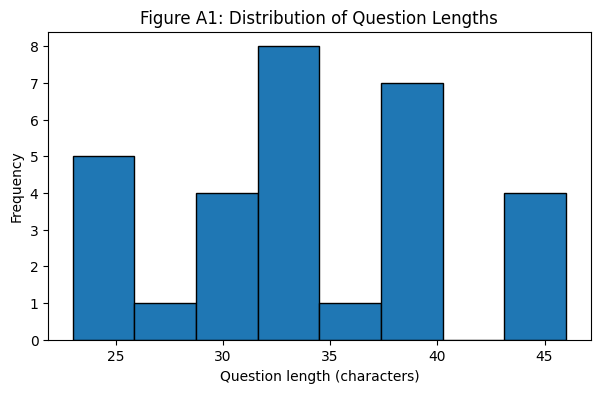

In [19]:
plt.figure(figsize=(7,4))
plt.hist(df_sec["q_len"], bins=8, edgecolor="black")
plt.title("Figure A1: Distribution of Question Lengths")
plt.xlabel("Question length (characters)")
plt.ylabel("Frequency")
plt.show()


### Figure A2 — Distribution of Answer Lengths
X: answer length (characters) • Y: frequency


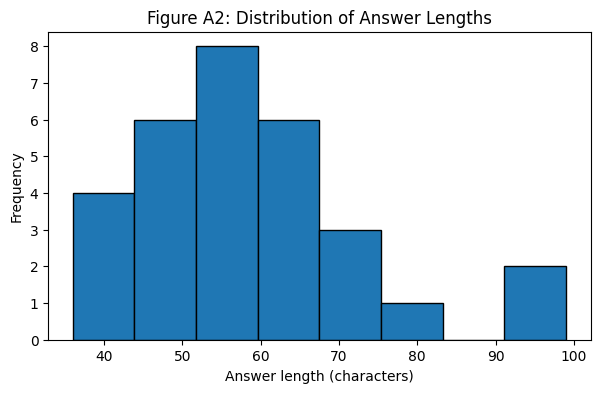

In [20]:
plt.figure(figsize=(7,4))
plt.hist(df_sec["a_len"], bins=8, edgecolor="black")
plt.title("Figure A2: Distribution of Answer Lengths")
plt.xlabel("Answer length (characters)")
plt.ylabel("Frequency")
plt.show()


### Figure C1 — Boxplot of Question vs Answer Lengths
X: type (Question, Answer) • Y: length (characters)


/tmp/ipython-input-2890301219.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_sec["q_len"], df_sec["a_len"]],


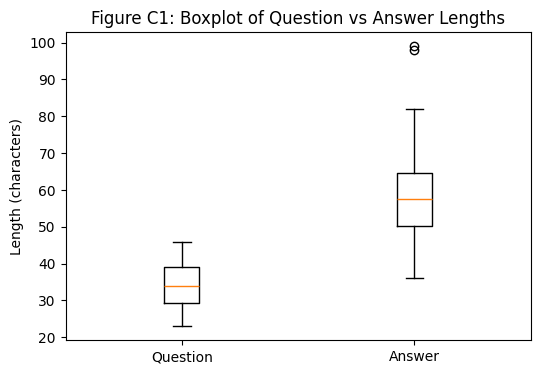

In [21]:
plt.figure(figsize=(6,4))
plt.boxplot([df_sec["q_len"], df_sec["a_len"]],
            labels=["Question","Answer"], showfliers=True)
plt.title("Figure C1: Boxplot of Question vs Answer Lengths")
plt.ylabel("Length (characters)")
plt.show()


## Correlation & Outliers
We measure Pearson correlation between question and answer lengths, then detect outliers via the IQR rule.


In [22]:
# Pearson correlation
corr = df_sec["q_len"].corr(df_sec["a_len"])
print(f"Pearson correlation (q_len vs a_len): {corr:.3f}")

# IQR outliers
Q1 = df_sec[["q_len","a_len"]].quantile(0.25)
Q3 = df_sec[["q_len","a_len"]].quantile(0.75)
IQR = Q3 - Q1
mask = (df_sec["q_len"] > Q3.q_len + 1.5*IQR.q_len) | (df_sec["a_len"] > Q3.a_len + 1.5*IQR.a_len)
outs = df_sec.loc[mask, ["id","question","answer","q_len","a_len"]]
print(f"\nOutliers count: {len(outs)}")
if len(outs):
    from IPython.display import display
    display(outs.head(5))


Pearson correlation (q_len vs a_len): -0.295

Outliers count: 2


,id,question,answer,q_len,a_len
0,1,ما هي البيانات الشخصية؟,كل معلومة تتعلق بفرد يمكن تحديده مباشرة أو غير...,23,98
1,2,ما هي البيانات الحساسة؟,البيانات المتعلقة بالصحة أو الدين أو السياسة أ...,23,99


## 4. Metadata Review

 #### The dataset used in this project was collected from the official Saudi Laws Portal managed by the Bureau of Experts at the Council of Ministers, which serves as the authoritative source of Saudi legal texts.

     Source: Saudi Laws Portal (https://laws.boe.gov.sa/boelaws/laws/lawdetails/b7cfae89-828e-4994-b167-adaa00e37188/1)

- Date Collected: September 2025

- Collection Method: Web scraping using Python libraries (requests, BeautifulSoup) to extract legal articles from the PDPL page. A raw HTML snapshot was stored for reproducibility.

- Language: Arabic

- Number of Records: 43 legal articles (19 original and 24 modified).

- Data Format: CSV (pdpl_articles_enhanced.csv and pdpl_cleaned.csv)

- Descriptive Statistics:

  - Average word count: ~91 words per article (min = 12, max = 508)

  - Average character length: ~544 characters (min = 70, max = 3112)

  - Most frequent words: “البيانات”، “الشخصية”، “جهة”، “التحكم”، “الجهة المختصة”

    *These statistics reveal a high variance in article length and linguistic concentration around specific legal terms, which reflects the formal language and structure of the PDPL. Such characteristics must be considered during analysis to avoid skewed interpretations.*

- Features:

  - article_title: Official title of each article.

  - article_text: Full legal text of each article.

  - article_status: Indicates whether the article is original, modified, or unknown.

  - modification_text: Amendment details if available.

  - category (added manually): Label assigned by the research team to classify articles thematically.

  - text_length: Number of characters in each article text.

  - word_count: Number of words in each article text.

**The secondary data:**

The original legal text sourced directly from the Saudi Laws Portal and manually added classification labels.

This metadata not only documents how the dataset was collected and structured but also provides analytical context that informs the EDA process and highlights potential biases and patterns in the legal text.

## 5. Bias Analysis


*The secondary dataset consists of 43 legal articles collected from the Saudi Laws Portal, with 24 modified articles and 19 original articles. Although the source is official and reliable, several biases can affect the interpretation of analytical results:*

1. **Source Bias**

All data originates from a single official governmental source, which reflects the formal legal language used by the state. This means it does not represent interpretations from other stakeholders such as legal practitioners, private institutions, or the public.

2. **Linguistic Bias**
The word frequency analysis showed heavy repetition of specific legal terms, such as:

“البيانات” (112 occurrences)

“الشخصية” (82 occurrences)

“جهة” (53 occurrences)

“التحكم” (37 occurrences)

“الجهة المختصة” (31 occurrences)
This repetition may dominate WordClouds and frequency plots, making other contextual words appear less significant — a common limitation in legal corpora.

3. **Distribution Bias**
The word count distribution is uneven:

Mean = 91 words

Min = 12 words (shortest article)

Max = 508 words (longest article)
Some articles are significantly longer than others (e.g., Article 1) and could skew average values or influence models trained on this data if not normalized properly.

4. **Temporal Bias**
The dataset reflects the PDPL as of September 2025. Since the law is subject to amendments, these findings might become outdated with future legal changes. This can affect the long-term validity of any derived insights.

5. **Collection Method Bias**
The dataset was collected via web scraping. Although validated, the extraction process depends on the structure of the web page (DOM). If this structure changes or if some content (e.g., popups) was missed, it could result in incomplete data.